In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from collections import Counter
import scipy
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn import metrics
import gget
import tabulate
from sklearn.neighbors import BallTree
from networkx.drawing.nx_agraph import graphviz_layout
from scipy.stats import gmean
import networkx as nx
import sys

# locals
sys.path.append('../')
import utils as ut

In [2]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)
cTypes = sorted(list(xy['cellTypes'].unique()))
print(cTypes)
print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']
    
    rf = ut.normalize(rf, 1e6)
    rna[key] = rf

print('done')

['B cells', 'Dendritic cells', 'Macrophages', 'Monocytes', 'NK cells', 'Stromal cells', 'T cells']

done


In [81]:
totcells = 0
for key in keys:
    rf = rna[key]
    print(rf.shape)
    
    totcells += rf.shape[0]
    
print(totcells)

(1261, 31053)
(6123, 31053)
(6436, 31053)
13820


In [73]:
UT = 0.025
"""
Ubiquitousness Index (0-1). 
0 indicates the gene is not expressed in any cell cluster and 
1 (maximum) indicates that the gene is expressed in all cell clusters. 
"""

# load gene lists 
pandPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"        
pandf = ut.read_panglaodb(pandPath)

cTypes = [
    'B cells', 
    'Dendritic cells',
    'Macrophages',
    'Monocytes', 
    'NK cells',
    'T cells', 
]

mf = pandf[pandf['cell type'].isin(cTypes)]
print(pd.DataFrame(mf['cell type'].value_counts()))
print()

mf = mf[mf['ubiquitousness index'] < UT]

print(pd.DataFrame(mf['cell type'].value_counts()))
print()

mf.head()


                 cell type
Macrophages            153
Dendritic cells        133
B cells                110
T cells                107
Monocytes              102
NK cells                98

                 cell type
Macrophages             90
Dendritic cells         82
NK cells                75
B cells                 74
T cells                 58
Monocytes               49



species official gene symbol cell type               nicknames  \
422   Mm Hs                  CD5   B cells                     NaN   
423   Mm Hs                MS4A1   B cells         Bp35|MS4A2|CD20   
424   Mm Hs                  CR2   B cells               CD21|C3DR   
425   Mm Hs                 CD22   B cells        SIGLEC-2|SIGLEC2   
426      Hs                FCER2   B cells  CLEC4J|CD23|CD23A|FCE2   

     ubiquitousness index             product description  \
422                 0.004                    CD5 molecule   
423                 0.014  membrane spanning 4-domains A1   
424                 0.001       complement C3d receptor 2   
425                 0.003                   CD22 molecule   
426                 0.002  Fc fragment of IgE receptor II   

               gene type  canonical marker germ layer          organ  \
422  protein-coding gene               1.0   Mesoderm  Immune system   
423  protein-coding gene               1.0   Mesoderm  Immune system   
424  protein-coding gene               1.0   Mesoderm  Immune system   
425  protein-coding gene               1.0   Mesoderm  Immune system   
426  protein-coding gene               1.0   Mesoderm  Immune system   

     sensitivity_human  sensitivity_mouse  specificity_human  \
422           0.000000           0.000000           0.004153   
423           0.483871           0.620155           0.011182   
424           0.048387           0.034884           0.000000   
425           0.096774           0.127907           0.001278   
426           0.016129           0.000000           0.001917   

     specificity_mouse   gene  
422           0.004502    CD5  
423           0.001566  MS4A1  
424           0.000000    CR2  
425           0.000196   CD22  
426           0.000000  FCER2

In [30]:
colors = {
    
    "B cells" : '#9e0142',
    "Dendritic cells" : '#e95c47',
    "Macrophages" : '#fdbf6f',
    "Monocytes" : '#ffffbe',
    'NK cells' : '#bfe5a0',
    "T cells" : '#5e4fa2',
}

colors

{'B cells': '#9e0142',
 'Dendritic cells': '#e95c47',
 'Macrophages': '#fdbf6f',
 'Monocytes': '#ffffbe',
 'NK cells': '#bfe5a0',
 'T cells': '#5e4fa2'}

key='ND' ctype='B cells'
key='ND' ctype='Dendritic cells'
key='ND' ctype='Macrophages'
key='ND' ctype='Monocytes'
key='ND' ctype='NK cells'
key='ND' ctype='T cells'
key='HFD8' ctype='B cells'
key='HFD8' ctype='Dendritic cells'
key='HFD8' ctype='Macrophages'
key='HFD8' ctype='Monocytes'
key='HFD8' ctype='NK cells'
key='HFD8' ctype='T cells'
key='HFD14' ctype='B cells'
key='HFD14' ctype='Dendritic cells'
key='HFD14' ctype='Macrophages'
key='HFD14' ctype='Monocytes'
key='HFD14' ctype='NK cells'
key='HFD14' ctype='T cells'


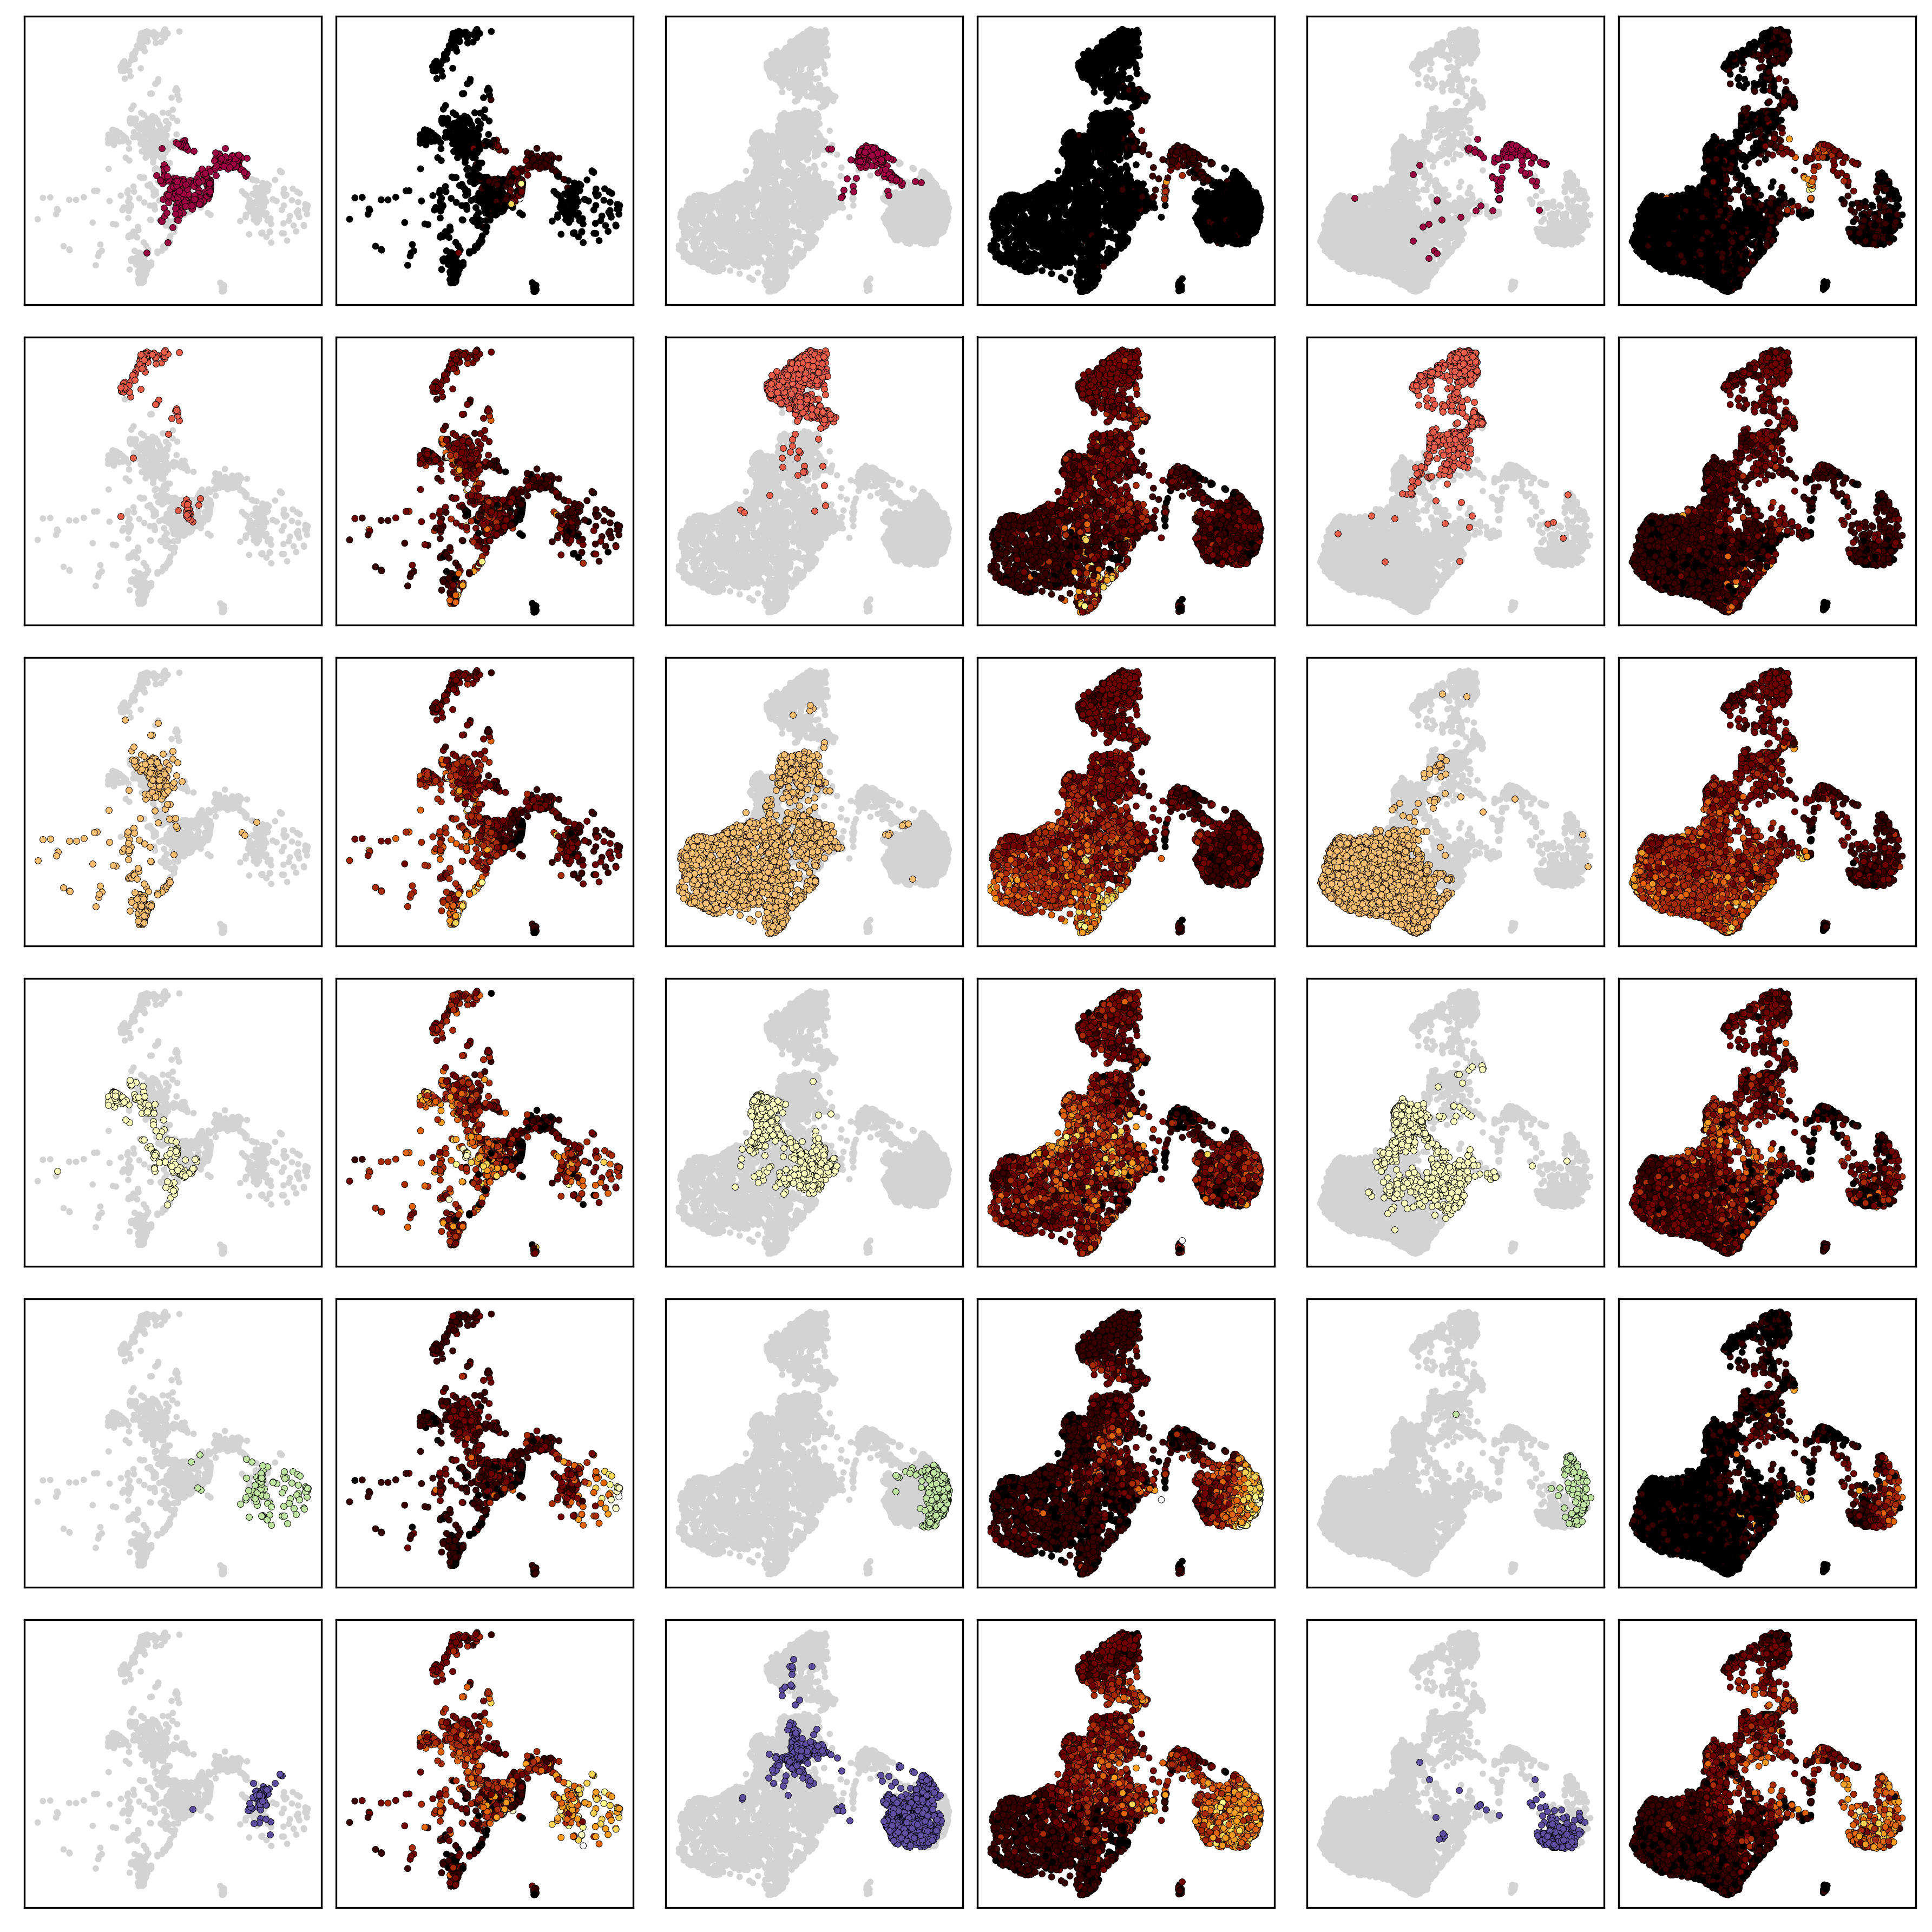

In [74]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 12, 12

mtypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

size = 8

fig, axs =  plt.subplots(6, 3)

for j, key in enumerate(keys):
    
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId').reset_index()
    lf['metatype'] = np.where(lf['cellType'].isin(mtypes), "Macrophages", lf['cellType'])
    
    
    for i, ctype in enumerate(cTypes):
        
        markers = mf[mf['cell type'] == ctype]['gene'].to_list()
        markers = [x for x in markers if x in rf.columns]
        ingroup = lf[lf['metatype'] == ctype]
        outgroup = lf[lf['metatype'] != ctype]
        expression = rf[markers].mean(axis=1)
        expression = np.sqrt(expression)
        
        # print(f"{key=} {ctype=} {ingroup.shape=} {len(cids)=} {len(markers)=} {expression.shape=} ")
        print(f"{key=} {ctype=}")
            
        sns.scatterplot(data=ingroup, 
                        x='x',
                        y='y',
                        color=colors[ctype],
                        ec='k',
                        s=size,
                        zorder=2,
                        ax=axs[i, j])
        
        sns.scatterplot(data=outgroup, 
                         x='x',
                         y='y',
                         color="lightgrey",
                         ec='None',
                         s=size,
                         zorder=1,
                         ax=axs[i, j])
        
        axs[i, j].set_ylabel('')
        axs[i, j].set_xlabel('')
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        
        """ Append expression """
        ax_divider = make_axes_locatable(axs[i, j])
        ax2 = ax_divider.append_axes("right", 
                                     size="100%", 
                                     pad=f"5%")
        
        sns.scatterplot(data=lf, 
                         x='x',
                         y='y',
                         c=list(expression),
                         ec='k',
                         cmap=plt.cm.get_cmap('afmhot', lut=10),
                         s=size,
                         zorder=1,
                         ax=ax2)
        
        ax2.set_ylabel('')
        ax2.set_xlabel('')
        ax2.set_yticks([])
        ax2.set_xticks([])
    
plt.tight_layout()
    
    

In [75]:
?ut.makeColorbar

Signature: ut.makeColorbar(cmap, width, hieght, title, orientation, tickLabels)
Docstring: <no docstring>
File:      ~/git_repositories/spatial_transcriptomics/clustering/utils.py
Type:      function


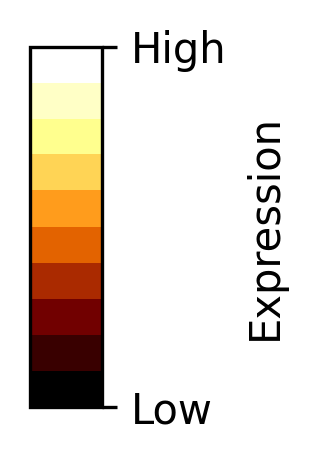

In [79]:
ut.makeColorbar(plt.cm.get_cmap('afmhot', lut=10), 
                0.3, 2, 
                "Expression", 
                "vertical",
                ['Low', 'High'])

In [82]:
for j, key in enumerate(keys):
    
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId').reset_index()
    lf['metatype'] = np.where(lf['cellType'].isin(mtypes), "Macrophages", lf['cellType'])
    
    
    for i, ctype in enumerate(cTypes):
        print(f"{key=} {ctype=}")
        
        markers = mf[mf['cell type'] == ctype]['gene'].to_list()
        markers = [x for x in markers if x in rf.columns]
        ingroup = lf[lf['metatype'] == ctype]
        outgroup = lf[lf['metatype'] != ctype]
        expression = rf[markers].mean(axis=1)
        expression = np.sqrt(expression)
        
        
    break